# Regional environmental reconstructions over the last millennium

In [63]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import string
import xarray as xr

In [64]:
## Metadata
data_path = 'data/env_reconstructions/'
#md = pd.read_csv(data_path+'records_md.csv',index_col=0, converters={'Longitude': eval,'Latitude': eval})
md = pd.read_csv(data_path+'records_md.csv',index_col=0)
md.at['SS_ISOW_Moffa_2015','Units']= '' 
md.at['SS_ISOW_Moffa_2017','Units']= ''

In [65]:
### Loading records in a dictionary
recs = dict.fromkeys(md.index.values)
separators = {'whitespace':'\s+','csv':',','tab':'\t'}
for ind,row in md.iterrows():
    try:
        rec_df = pd.read_csv(data_path+row['file'], comment='#', sep=separators[row['separator']],\
                             index_col=row['Index_col'])
    except:
        rec_df = pd.read_csv(data_path+row['file'], comment='#', sep=separators[row['separator']],\
                             index_col=row['Index_col'],encoding = "ISO-8859-1")
    if row['Time_ref'] == 'BP':
        time_factor = 1 if np.isnan(row['Time_factor']) else row['Time_factor']
        rec_df['age_AD'] = 1950 - rec_df.index*time_factor
        rec_df.set_index('age_AD',inplace=True)
    if not math.isnan(row['nan_val']):
        rec_df = rec_df.replace(row['nan_val'], np.NaN)
    rec_df[row['Column']].replace("-",np.nan,inplace=True)
    if ind == 'Volc_RF_Sigl_2015':
        gvf = pd.DataFrame({'Year_CE' : range(rec_df.index.min(),rec_df.index.max()+1)})
        gvf = gvf.merge(rec_df,on="Year_CE",how='outer')
        gvf.set_index('Year_CE',inplace=True)
        gvf = gvf.fillna(0)
        rec_df = gvf
    if ind in  ['SBT_MFNorw_Cunningham_2013','SST_d18O_Cunningham_2013']: ### Cutting out the last years for visualisation purposes
        rec_df = rec_df[rec_df.index<1960]
    if ind == 'SBT_MFNorw_Cunningham_2013':
        rec_df = rec_df[rec_df.index<1800]
    recs[ind] = pd.to_numeric(rec_df[row['Column']][rec_df.index>900])

In [66]:
### d18O difference in two foraminifera in the Labrador Sea as a proxy for the relative influence of Atlantic waters
delta_d18O = recs['d18O_LS_Npachy_Moffa_2017'] - recs['d18O_LS_Tquin_Moffa_2017']
recs['delta_d18O_LS'] = delta_d18O
md.loc['delta_d18O_LS'] = md.loc['d18O_LS_Npachy_Moffa_2017']

In [67]:
## Selection of records to plot
recs_na = {### SST or d18O records
               'IP25_NIS_Masse_2008': {'smooth':False,'invert':False,'color':'tab:orange','size':12,'movelon':0.5},
                #'SSTcomp_Norw_Cunningham_2013': {'smooth':False,'invert':False,'color':'tab:orange','size':10},               
               'd18O_Stor_Sejrup_2011': {'smooth':False,'invert':True,'color':'tab:purple','ylim':(0.9,1.5)},
               #'SBT_MFNorw_Cunningham_2013': {'smooth':False,'invert':False,'color':'tab:olive','size':10},
               'SST_d18O_Cunningham_2013': {'smooth':False,'invert':True,'color':'tab:gray','size':10},
               'SST_Norw_Berner_2011': {'smooth':False,'invert':False,'color':'tab:olive','size':10},
               #'SSTcomp_Iceland_Cunningham_2013': {'smooth':False,'invert':False,'color':'tab:blue','size':10},               
               'SST_SI_Moffa_2014': {'smooth':2,'ylim':(5.5,10.3),'invert':False,'color':'tab:green'}, 
               'SST_NIS_Jiang': {'smooth':False,'invert':False,'color':'tab:blue','tephra':False,'size':6,'movelon':0.5},
               #'d18O_LS_Tquin_Moffa_2017': {'smooth':2,'invert':True,'units':'‰','color':'tab:orange'},
               #'SST_SI_Miettinen_2012': {'smooth':False,'invert':False,'color':'tab:red'},
               'AMV_NA_Lapointe': {'smooth':10,'ylim':(21.8,22.6),'invert':False,'color':'k'},
               #'SBT_MFNorw_Cunningham_2013': {'smooth':False,'invert':False,'color':'tab:purple'},
               #'SST_NIS_Sicre': {'smooth':False,'invert':False,'color':'tab:cyan','size':10,'tephra':True},
               ### Proxies for changes in circulation
               'eNd_RockTrou_Copard_2012': {'smooth':False,'invert':True,'color':'navy'},
               #'delta_d18O_LS':{'smooth':2,'invert':False,'variable':'$\Delta \delta^{18}O_{Nps-Tq}$','units':'‰','color':'tab:orange'},
               'SS_ISOW_Moffa_2017': {'smooth':2,'invert':True,'units':'μm','color':'tab:red'},
               #'SS_ISOW_Moffa_2015': {'smooth':2,'invert':False,'units':'μm','color':'tab:green'},                
               'SS_NwAC_Tegzes_2017':{'smooth':2,'invert':False,'units':'μm','color':'darkcyan','size':5},
               ### Ice records               
               #'SIC_Miettinen_2015': {'smooth':False,'invert':False,'ylim':(18,90),'color':'lightseagreen'},
               #'IRD_Alonso_2017': {'smooth':4,'invert':False,'color':'mediumvioletred'},
               ### External forcing
               #'NAOcc_Ortega_2015': {'smooth':20,'invert':False,'color':'k'},
               'SolMod_global_Brehm_2021': {'smooth':200,'invert':False,'color':'red'},
               'Volc_RF_Sigl_2015': {'smooth':False,'invert':True,'color':'tab:brown'}
               }

In [68]:
### Data containing the tephra markers
tephra_file = 'md992275-tephra-layers.txt'
tephra = pd.read_csv(data_path+tephra_file, comment='#',delim_whitespace=True)
tephra_yr = 1950 - tephra['Tephra-age-(years-BP)'] ### Tephra age (bp): age of tephra layer, years before 1950AD

### Some notable regional reconstructions

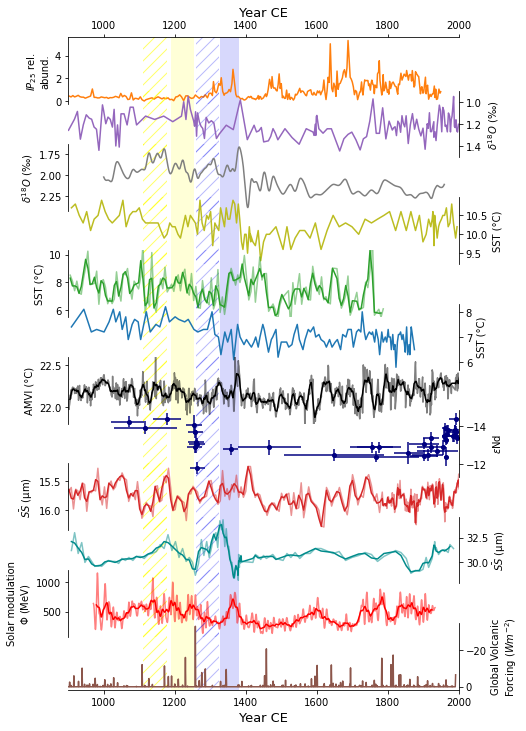

In [72]:
fig, axs = plt.subplots(len(recs_na),1, figsize=(7,12),gridspec_kw={'hspace': -0.2},facecolor='white')
for i,(irec,params) in enumerate(recs_na.items()):
    if irec == 'eNd_RockTrou_Copard_2012':
        rec_df = pd.read_csv(data_path+'copard_2012_corals_Nd.csv', comment='#', delimiter=r"\s+|,",\
                         index_col=0,engine='python')
        rec_df = rec_df.sort_index(ascending=True)
        rec_df = rec_df[rec_df.index>900]
        axs[i].errorbar(rec_df['eNd'].index, rec_df['eNd'].values,xerr=rec_df['Age_unc'], \
            yerr=rec_df['eNd_uncert'],fmt='.',markersize='8',color=params['color'])
    else:
        if params['smooth'] == False:
            recs[irec].plot(ax=axs[i],color=params['color'])
        else:
            recs[irec].dropna().plot(ax=axs[i],color=params['color'],alpha=0.5)
            recs[irec].dropna().rolling(params['smooth'],center=True).mean().plot(ax=axs[i],color=params['color'])
    
    
    
    unit_str = md.loc[irec]['Units'] if 'units' not in params.keys() else params['units']
    units = ' (' + unit_str +')' if type(unit_str) == str else ''
    
    variable = md.loc[irec]['Variable'] if 'variable' not in params.keys() else params['variable']
    if len(str(variable)) > 16 and "Delta" not in str(variable):
        lab_spl = str(variable).split(' ')
        if len(lab_spl) > 1:
            label = ' '.join(lab_spl[:-1]) + '\n' + lab_spl[-1]
    else:
        label = str(variable)
    ylab = label + units
    
    axs[i].set_ylabel(ylab)
    if 'ylim' in params.keys():
        axs[i].set_ylim(params['ylim'])
    if params['invert'] == True:
        axs[i].invert_yaxis()
    if 'tephra' in params.keys():      
        ## Tephra layers
        teph_layers = tephra_yr[tephra_yr>900]
        if params['tephra'] == True:
            [axs[i].axvspan(xmin=ly-3,xmax=ly+3,ymin=0.3, ymax=0.33,color='k') for ly in teph_layers];
### Subplots arrangement        
for i in range(0,len(recs_na)):
    axs[i].set_xlabel('')
    axs[i].set_xlim(900,2000)
    axs[i].patch.set_facecolor('None')
    axs[i].axvspan(1190, 1255, ymin=0, ymax=0.8 if i!=0 else 1, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].axvspan(1327, 1380, ymin=0, ymax=0.8 if i!=0 else 1, color=(0/255,7/255,241/255,40/255), lw=0)
    axs[i].axvspan(1110,1179,hatch="//", facecolor="none",edgecolor=(255/255,255/255,0,150/255), lw=0)
    axs[i].axvspan(1260,1326,hatch="//", facecolor="none",edgecolor=(0/255,7/255,241/255,70/255), lw=0)
    if i !=0:

        axs[i].spines['top'].set_visible(False)
        if i != len(recs_na)-1:
            axs[i].set_xticks([])    
    if i != len(recs_na)-1:
        axs[i].spines['bottom'].set_visible(False)    
    if i%2 == 0:
        axs[i].tick_params(axis="y", right=False, left=True, labelright=False, labelleft=True)
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_label_position("left")
    else:
        axs[i].tick_params(axis="y", right=True, left=False, labelright=True, labelleft=False)
        axs[i].spines['left'].set_visible(False)
        axs[i].yaxis.set_label_position("right")
#axs[-1].invert_yaxis()
axs[0].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
axs[0].set_xlabel('Year CE',fontsize=13)
axs[-1].set_xlabel('Year CE',fontsize=13)
axs[0].xaxis.set_label_position("top")
fig.savefig('img/rec_subpolarNA_rev.png',dpi=200, bbox_inches='tight')

In [34]:
#NOAA ETOPO Global relief model https://www.ngdc.noaa.gov/mgg/global/global.html
img = plt.imread('../../../datasets/color_etopo1_ice_low.jpg') 
## April 2016 SST data from the European Space Agency (ESA)'s Climate Change Initiative (CCI) programme.
## https://dap.ceda.ac.uk/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/2016/04/
path = '../../../datasets/CCI_sst/'
cci_apr_f = '20160411120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR2.0-v02.0-fv01.0.nc'
cci_sst_apr= xr.open_mfdataset(path+cci_apr_f,combine='by_coords')
cci_sst_apr = cci_sst_apr.assign(analysed_sst=cci_sst_apr.analysed_sst-273.15)

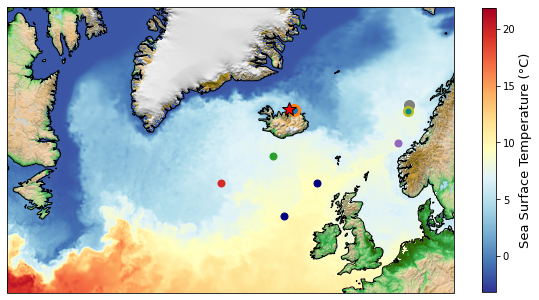

In [39]:
map_recs = [r for r,_ in recs_na.items() if r not in ['Volc_RF_Sigl_2015','SolMod_global_Brehm_2021','NAOcc_Ortega_2015']]
longitude = float(md.loc['d18O_Reynolds_2016'].Longitude)
latitude = float(md.loc['d18O_Reynolds_2016'].Latitude)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection = ccrs.EquidistantConic(central_longitude=0.0, central_latitude=50.0, false_easting=20.0, false_northing=80.0, standard_parallels=(20.0, 50.0), globe=None))# create a set of axes with Mercator projection
ax.set_extent([-60.483, 12.64, 47.733,70.14])
for i,(rec_id,rec) in enumerate(md.loc[map_recs].iterrows()):
    lon,lat = eval(rec.Longitude), eval(rec.Latitude)
    if 'movelon' in recs_na[rec_id].keys():
        lon += recs_na[rec_id]['movelon'] 
    #ax.plot(lon,lat, 'o', markersize=9 if i==0 else 6,color=colors[i], transform=ccrs.Geodetic())
    size = 7 if 'size' not in recs_na[rec_id].keys() else recs_na[rec_id]['size']
    ax.plot(lon,lat, 'o', markersize=size,color=recs_na[rec_id]['color'], transform=ccrs.Geodetic())
ax.plot(longitude,latitude, '*', markersize=14,color='red', transform=ccrs.Geodetic(),markeredgecolor='k')
ax.coastlines(resolution='50m')
ax.imshow(img, origin='upper', transform=ccrs.PlateCarree())
cmap = cci_sst_apr.analysed_sst.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',vmin=-3.15,vmax=21.85,add_colorbar=False)
ax.set_title('');
cbar = fig.colorbar(cmap, ax=ax, shrink=0.87)
cbar.ax.set_ylabel(r'Sea Surface Temperature (°C)', fontsize=13);
fig.savefig('img/NA_map_biv_site.png',dpi=300, bbox_inches='tight')

In [58]:
recs_suppl ={'SBT_MFNorw_Cunningham_2013': {'smooth':False,'invert':False,'color':'tab:orange'},
             'SS_ISOW_Moffa_2015': {'smooth':2,'invert':False,'units':'μm','color':'tab:green'}, 
             'delta_d18O_LS':{'smooth':2,'invert':False,'variable':r'$\Delta \delta^{18}O_{Nps-Tq}$','units':'‰','color':'rebeccapurple'}}

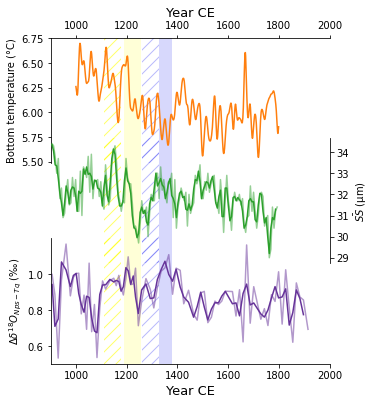

In [61]:
#colors = ['tab:blue','rebeccapurple','lightseagreen','tab:orange','tab:grey','tab:olive','tab:green','tab:brown','navy','lightcoral']
rec_to_plot = recs_suppl
fig, axs = plt.subplots(len(rec_to_plot),1, figsize=(5,6),gridspec_kw={'hspace': -0.2},facecolor='white')
for i,(irec,params) in enumerate(rec_to_plot.items()):
    if irec == 'eNd_RockTrou_Copard_2012':
        rec_df = pd.read_csv(data_path+'copard_2012_corals_Nd.csv', comment='#', delimiter=r"\s+|,",\
                         index_col=0,engine='python')
        rec_df = rec_df.sort_index(ascending=True)
        rec_df = rec_df[rec_df.index>900]
        axs[i].errorbar(rec_df['eNd'].index, rec_df['eNd'].values,xerr=rec_df['Age_unc'], \
            yerr=rec_df['eNd_uncert'],fmt='.',markersize='8',color=params['color'])
    else:
        if params['smooth'] == False:
            recs[irec].plot(ax=axs[i],color=params['color'])
        else:
            recs[irec].dropna().plot(ax=axs[i],color=params['color'],alpha=0.5)
            recs[irec].dropna().rolling(params['smooth'],center=True).mean().plot(ax=axs[i],color=params['color'])
    #axs[i].text(0.02, 0.75, string.ascii_uppercase[i], transform=axs[i].transAxes, size=12,weight='bold')
    
    unit_str = md.loc[irec]['Units'] if 'units' not in params.keys() else params['units']
    units = ' (' + unit_str +')' if type(unit_str) == str else ''
    
    variable = md.loc[irec]['Variable'] if 'variable' not in params.keys() else params['variable']
    if len(str(variable)) > 30:
        lab_spl = str(variable).split(' ')
        if len(lab_spl) > 1:
            label = ' '.join(lab_spl[:-1]) + '\n' + lab_spl[-1]
    else:
        label = str(variable)
    ylab = label + units
    
    axs[i].set_ylabel(ylab)
    if 'ylim' in params.keys():
        axs[i].set_ylim(params['ylim'])
    if params['invert'] == True:
        axs[i].invert_yaxis()

## Tephra layers
#teph_layers = tephra_yr[tephra_yr>900]
#[axs[1].axvspan(xmin=ly-3,xmax=ly+3,ymin=0.3, ymax=0.33,color='k') for ly in teph_layers];
### Subplots arrangement        
for i in range(0,len(rec_to_plot)):
    axs[i].set_xlabel('')
    axs[i].set_xlim(900,2000)
    axs[i].patch.set_facecolor('None')
    axs[i].axvspan(1190, 1255, ymin=0, ymax=0.8 if i!=0 else 1, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].axvspan(1327, 1380, ymin=0, ymax=0.8 if i!=0 else 1, color=(0/255,7/255,241/255,40/255), lw=0)
    axs[i].axvspan(1110,1179,hatch="//", facecolor="none",edgecolor=(255/255,255/255,0,150/255), lw=0)
    axs[i].axvspan(1260,1326,hatch="//", facecolor="none",edgecolor=(0/255,7/255,241/255,70/255), lw=0)
    if i !=0:

        axs[i].spines['top'].set_visible(False)
        if i != len(rec_to_plot)-1:
            axs[i].set_xticks([])    
    if i != len(rec_to_plot)-1:
        axs[i].spines['bottom'].set_visible(False)    
    if i%2 == 0:
        axs[i].tick_params(axis="y", right=False, left=True, labelright=False, labelleft=True)
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_label_position("left")
    else:
        axs[i].tick_params(axis="y", right=True, left=False, labelright=True, labelleft=False)
        axs[i].spines['left'].set_visible(False)
        axs[i].yaxis.set_label_position("right")
#axs[-1].invert_yaxis()
axs[0].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
axs[0].set_xlabel('Year CE',fontsize=13)
axs[-1].set_xlabel('Year CE',fontsize=13)
axs[0].xaxis.set_label_position("top")
fig.savefig('img/rec_suppl_mat.png',dpi=200, bbox_inches='tight')

/home/ra499/.local/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ra499/.local/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ra499/.local/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


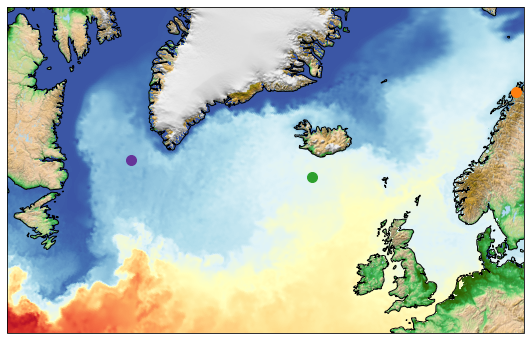

In [62]:
map_recs = [r for r,_ in recs_suppl.items() if r not in ['Volc_RF_Sigl_2015','SolMod_global_Brehm_2021','NAOcc_Ortega_2015']]
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection = ccrs.EquidistantConic(central_longitude=0.0, central_latitude=50.0, false_easting=20.0, false_northing=80.0, standard_parallels=(20.0, 50.0), globe=None))# create a set of axes with Mercator projection
ax.set_extent([-60.483, 13.5, 47.733,70.14])
for i,(rec_id,rec) in enumerate(md.loc[map_recs].iterrows()):
    lon,lat = eval(rec.Longitude), eval(rec.Latitude)
    if 'movelon' in recs_suppl[rec_id].keys():
        lon += recs_suppl[rec_id]['movelon'] 
    #ax.plot(lon,lat, 'o', markersize=9 if i==0 else 6,color=colors[i], transform=ccrs.Geodetic())
    size = 10 if 'size' not in recs_suppl[rec_id].keys() else recs_suppl[rec_id]['size']
    ax.plot(lon,lat, 'o', markersize=size,color=recs_suppl[rec_id]['color'], transform=ccrs.Geodetic())
#ax.plot(longitude,latitude, '*', markersize=14,color='red', transform=ccrs.Geodetic(),markeredgecolor='k')
ax.coastlines(resolution='50m')
ax.imshow(img, origin='upper', transform=ccrs.PlateCarree())
cmap = cci_sst_apr.analysed_sst.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',vmin=-3.15,vmax=21.85,add_colorbar=False)
ax.set_title('');
#cbar = fig.colorbar(cmap, ax=ax, shrink=0.87)
#cbar.ax.set_ylabel(r'Sea Surface Temperature (°C)', fontsize=13);
fig.savefig('img/map_NA_suppl.png',dpi=300, bbox_inches='tight')